# Get ready : module download etc.

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git
# Install matplotlib in proper version
! pip install matplotlib==3.1.3

  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-things 0.0.1 requires matplotlib>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.


In [3]:
# Install wandb
! pip install wandb

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# Easy Data Augmentation

In [5]:
import random
import pickle
import re

wordnet = {}
with open("./kwordnet/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	# sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	# ri
	for _ in range(num_new_per_technique):
		a_words = random_insertion(words, n_ri)
		augmented_sentences.append(' '.join(a_words))

	# rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(" ".join(a_words))

	# rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(" ".join(a_words))

	augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences

In [6]:
! pip install pandas

# Data load

In [7]:
import pickle as pickle
import os
import pandas as pd
import torch

class news_dataset(torch.utils.data.Dataset):
    """Dataset 구성을 위한 class."""

    def __init__(self, news_dataset, labels):
        self.news_dataset = news_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: val[idx].clone().detach() for key, val in self.news_dataset.items()
        }
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def load_data(dataset_dir):
    """csv 파일을 경로에 맡게 불러 옵니다."""
    pd_dataset = pd.read_csv(dataset_dir)
    
    print("Augmentation start.")
    
    for i in range(len(pd_dataset)):
        tmp = pd_dataset.iloc[i, 3]
        tmp = EDA(tmp)
        for sentence in tmp :
            pd_dataset = pd_dataset.append({'class' : pd_dataset.iloc[i, 2], 'conversation' : sentence}, ignore_index=True)
    
    print("Augmentation done.")
    return pd_dataset


def tokenized_dataset(dataset, tokenizer, max_length):
    """tokenizer에 따라 sentence를 tokenizing 합니다."""
    concat_entity = []
    for temp in dataset['conversation']:
        concat_entity.append(temp)

    tokenized_sentences = tokenizer(
        concat_entity,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,
        return_token_type_ids=False, #BERT ->  RoBERTa 120, 20 100 밥을 먹었다 [PAD] [PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD] [1 1 1 00000000]
    )
    # Tokenizer : sentence -> token_id , attention mask , token_type_ids => 첫번째 문장과 두번째 문장 표시 00000000 111111111
    return tokenized_sentences

# Train

In [8]:
import os
import random
import argparse

import numpy as np
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import random_split
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
)

from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup

import wandb

# ------* Fix Seeds * -----------#
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def compute_metrics(pred):
    """validation을 위한 metrics function"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1) #argmax([0.01 0.0001 0.1])

    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
    }


def label_to_num(label):
    dict_label_to_num = {
        '일반':0, '갈취':1, '협박':2, '직장 내 괴롭힘':3, '기타 괴롭힘':4
    }
    num_label = []

    for v in label:
        num_label.append(dict_label_to_num[v])

    return num_label


def train():
    # fix a seed
    seed_everything(seed)
    
    # load model and tokenizer
    MODEL_NAME = model_name # klue/roberta-base
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # load dataset
    org_dataset = load_data('./dataset/train.csv')
    # test_dataset = load_data("..data/newszum_test_data.csv")

    org_label = label_to_num(org_dataset["class"].values)
    # test_label = label_to_num(test_dataset["class"].values)

    # tokenizing dataset
    tokenized_corpus = tokenized_dataset(org_dataset, tokenizer, max_len)
    # tokenized_test = tokenized_dataset(test_dataset, tokenizer, max_len)

    # make dataset for pytorch.
    voc_dataset = news_dataset(tokenized_corpus, org_label)
    # news_test_dataset = news_dataset(tokenized_test, test_label)

    # defining split_size
    dataset_size = len(voc_dataset)
    train_size = int(dataset_size * 0.8)
    validation_size = int(dataset_size * 0.1)
    test_size = dataset_size - train_size - validation_size

    # random split
    global train_dataset, valid_dataset, test_dataset

    train_dataset, valid_dataset, test_dataset = random_split(voc_dataset, [train_size, validation_size, test_size])

    print(f"Training Data Size : {len(train_dataset)}")
    print(f"Validation Data Size : {len(valid_dataset)}")
    print(f"Testing Data Size : {len(test_dataset)}")
    print()
    print()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device) #a.device ,b => a*b XX

    # setting model hyperparameter
    model_config = AutoConfig.from_pretrained(MODEL_NAME)
    model_config.num_labels = 5

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, config=model_config
    )

    print(model.config)
    model.parameters
    model.to(device)

    ### callback & optimizer & scheduler 추가
    MyCallback = EarlyStoppingCallback(
        early_stopping_patience=3, early_stopping_threshold=0.001
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=weight_decay,
        amsgrad=False,
    )

    training_args = TrainingArguments(
      output_dir = save_path + '/results',
      save_total_limit = save_limit,
      save_steps = save_step,
      num_train_epochs = epochs,
      learning_rate = lr,
      per_device_train_batch_size = batch_size,
      per_device_eval_batch_size = per_device_eval_batch_size,
      warmup_steps = warmup_steps,
      weight_decay = weight_decay,
      logging_dir = save_path + '/logs',
      logging_steps = 10,
      evaluation_strategy = 'steps',
      gradient_accumulation_steps = 20,
      eval_accumulation_steps = 20,
      report_to = "wandb",

      eval_steps = eval_steps,
      load_best_model_at_end = True,
    )

    trainer = Trainer(
      model = model,
      args = training_args,
      train_dataset=train_dataset,  # training dataset
      eval_dataset=valid_dataset,  # evaluation dataset
      compute_metrics=compute_metrics,  # define metrics function
      callbacks=[MyCallback],
      optimizers=(
        optimizer,
        get_cosine_with_hard_restarts_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=len(train_dataset) * epochs,
            ),
        ),
    )

    # train model
    trainer.train()
    model.save_pretrained(save_path + "/best_model")

def main():
    train()

In [10]:
if __name__ == "__main__":
    %env WANDB_LOG_MODEL=true
    save_path = './model/bert/2nd'

    model_name = "klue/roberta-base"
    seed = 42
    max_len = 200
    save_limit = 5
    save_step = 20
    epochs = 10
    lr = 5e-4
    batch_size = 8
    per_device_eval_batch_size = 2
    warmup_steps = 100
    weight_decay = 0.005
    logging_steps = 5

    eval_steps = 20
    load_best_model_at_end = True

    # fix a seed
    seed_everything(seed)
    wandb.login()
    wandb.init(project='huggingface3',
               entity='ethicsense',
               name='VocClassification+augm')
    main()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: WANDB_LOG_MODEL=true


Augmentation start.
Augmentation done.
Training Data Size : 69511
Validation Data Size : 8688
Testing Data Size : 8690


cuda:0


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classif

RobertaConfig {
  "_name_or_path": "klue/roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertTokenizer",
  "transformers_version": "4.20.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32000
}



***** Running training *****
  Num examples = 69511
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 20
  Total optimization steps = 4340
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
20,0.756700,0.450586,0.860612
40,0.285900,0.282761,0.905847
60,0.286700,0.223442,0.938306
80,0.280500,0.219399,0.930594
100,0.387200,0.254813,0.924378
120,0.503500,0.454609,0.905502
140,0.930400,2.444431,0.580110


***** Running Evaluation *****
  Num examples = 8688
  Batch size = 2
Saving model checkpoint to ./model/bert/2nd/results/checkpoint-20
Configuration saved in ./model/bert/2nd/results/checkpoint-20/config.json
Model weights saved in ./model/bert/2nd/results/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8688
  Batch size = 2
Saving model checkpoint to ./model/bert/2nd/results/checkpoint-40
Configuration saved in ./model/bert/2nd/results/checkpoint-40/config.json
Model weights saved in ./model/bert/2nd/results/checkpoint-40/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8688
  Batch size = 2
Saving model checkpoint to ./model/bert/2nd/results/checkpoint-60
Configuration saved in ./model/bert/2nd/results/checkpoint-60/config.json
Model weights saved in ./model/bert/2nd/results/checkpoint-60/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 8688
  Batch size = 2
Saving model checkpoint to ./model/bert/2nd/results/checkpoi

# Inference

In [11]:
# 한글폰트 적용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnuma1
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/shar

In [12]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn.functional as F

import numpy as np
import argparse
from tqdm import tqdm
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score

def inference(model, tokenized_sent, device):
    """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
    """
    dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
    model.eval()
    # Tracking variables
    predictions_labels = []
    true_labels = []
    #total loss for this epoch.
    total_loss = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        
        with torch.no_grad():
            
            outputs = model(**batch)
            # print(outputs[0])
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            result = np.argmax(logits, axis=-1).flatten().tolist()
            predictions_labels += result

        avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


def num_to_label(label):
    """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
    """
    origin_label = []
    dict_num_to_label = {
        0:'일반', 1:'갈취', 2:'협박', 3:'직장 내 괴롭힘', 4:'기타 괴롭힘'
    }

    for v in label[0]:
        origin_label.append(dict_num_to_label[v])

    return origin_label


def load_test_dataset(dataset_dir, tokenizer):
    """
    test dataset을 불러온 후,
    tokenizing 합니다.
    """
    test_dataset = load_data(dataset_dir)
    test_label = list(map(int, test_dataset["class"].values))

#     tokenizing dataset
    tokenized_test = tokenized_dataset(test_dataset, tokenizer, 384)
    
    return tokenized_test, test_label


def main():
    """
    주어진 dataset csv 파일과 같은 형태일 경우 inference 가능한 코드입니다.
    """
    global model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # load tokenizer
    Tokenizer_NAME = model
    tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

    ## load my model
    MODEL_NAME = model_dir  # model dir.

    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    # model.parameters
    model.to(device)
    labels_ids = {'일반':0, '갈취':1, '협박':2, '직장 내 괴롭힘':3, '기타 괴롭힘':4}

    true_labels, predictions_labels, avg_epoch_loss = inference(model, test_dataset, device)


    evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))

    print(evaluation_report)


    plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                          classes=list(labels_ids.keys()), normalize=True, 
                          magnify=0.1,
                          );

loading file https://huggingface.co/klue/roberta-base/resolve/main/vocab.txt from cache at /home/gycksdl94/.cache/huggingface/transformers/e8441a174492958462b6b16b6db8f1e7253cd149ca779522cadd812d55091b89.d1b86bed49516351c7bb29b19d7e7be2ab53b931bcb1f9b2aacfb71f2124d25a
loading file https://huggingface.co/klue/roberta-base/resolve/main/tokenizer.json from cache at /home/gycksdl94/.cache/huggingface/transformers/233a5b2c17873a8477b62dd92a02092a9937759e924a5f22b111becebb8aba5e.44c30ade4958fcfd446e66025e10a5b380cdd0bbe9b3fb7a794f357e7f0f34c2
loading file https://huggingface.co/klue/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/klue/roberta-base/resolve/main/special_tokens_map.json from cache at /home/gycksdl94/.cache/huggingface/transformers/9d0c87e44b00acfbfbae931b2e4068eb6311a0c3e71e23e5400bdf57cab4bfbf.70c17d6e4d492c8f24f5bb97ab56c7f272e947112c6faf9dd846da42ba13eb23
loading file https://huggingface.co/klue/roberta-base/resolve/main/tok

              precision    recall  f1-score   support

          일반       1.00      1.00      1.00      4362
          갈취       0.75      0.94      0.83      1085
          협박       0.91      0.78      0.84       942
    직장 내 괴롭힘       0.97      0.87      0.92      1070
      기타 괴롭힘       0.87      0.85      0.86      1231

    accuracy                           0.93      8690
   macro avg       0.90      0.89      0.89      8690
weighted avg       0.94      0.93      0.93      8690

Normalized confusion matrix


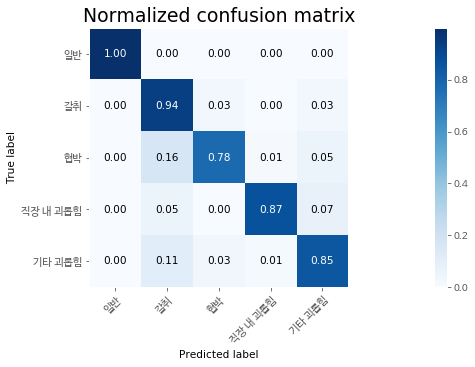

In [17]:
if __name__ == "__main__":

    # model dir
    model = 'klue/roberta-base'
    model_dir = save_path + '/best_model'
    main()